 <!-- SVM, Small VGG Network, ArcFace, FCapNetwork -->

In [1]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


image_size = (224, 224, 3)
dataset_path = "data"

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', '.DS_Store', 'Grupo_4', 'Grupo_3', 'Grupo_2', 'Grupo_5']


Step 1: Loading DataSet, LG Folder - 29 Subjects, with one corrupt sample

In [2]:
def load_images_from_folder(folder_path, max_depth=5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            # Resize image to 224x224x3 for ResNet50
                            img = cv2.resize(img, (224, 224))
                            images.append(img)
                            # Binary label, '0' means Fit for Duty, others alcoholic
                            labels.append(file[6] != '0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)
        else:
            del dirs[:]

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    return np.array(images), np.array(labels), np.array(names)

images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")


Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 224, 224, 3)


Randome index: 461


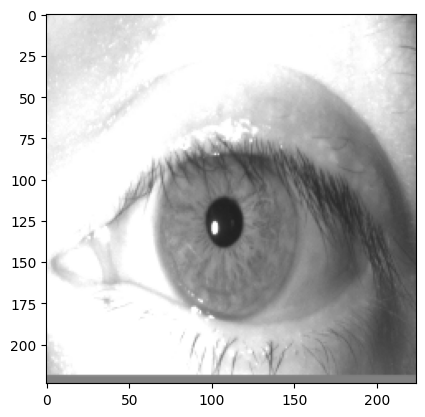

In [3]:
ri = random.randint(0, len(images) - 1)
print("Randome index: " + str(ri))
plt.imshow(images[ri])

In [4]:
#Splitting Classes
alcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 1]
nonAlcoholicClass = [images[i] for i in range(len(labels)) if labels[i] == 0]

alcoholicClass = np.array(alcoholicClass)
nonAlcoholicClass = np.array(nonAlcoholicClass)

In [5]:
#Data Generator Setup
datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.025,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
#Augmentation:

n1 = len(nonAlcoholicClass)
n2 = len(alcoholicClass)
target_size = n2
augmentation_needed = target_size - n1

print(f'Number of samples in Class 1 (FFD): {n1}')
print(f'Number of samples in Class 2 (Non Alcoholic): {n2}')
print(f'Augmenting {augmentation_needed} images for Class 1 to match Class 2.')

augmented_images = []
for i in range(augmentation_needed):
    img = nonAlcoholicClass[i % n1]  
    img = np.expand_dims(img, axis=0)  
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_img = augmented_img.astype(int)
    augmented_images.append(augmented_img)

augmented_images = np.array(augmented_images)

concagtedClassNon = np.concatenate([nonAlcoholicClass, augmented_images], axis=0)

print(f'New size of Class 1: {len(alcoholicClass)}')
print(f'New size of Class 2: {len(concagtedClassNon)}')



Number of samples in Class 1 (FFD): 580
Number of samples in Class 2 (Non Alcoholic): 2240
Augmenting 1660 images for Class 1 to match Class 2.
New size of Class 1: 2240
New size of Class 2: 2240


In [7]:
#concat classes
alcoholic_labels = np.ones(len(alcoholicClass))
nonAlcoholic_labels = np.zeros(len(concagtedClassNon))

images = np.concatenate([alcoholicClass, concagtedClassNon], axis=0)
labels = np.concatenate([alcoholic_labels, nonAlcoholic_labels], axis=0)

shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
labels = labels[shuffled_indices]

print(f"Total number of images after augmentation: {len(images)}")
print(f"Shape of final images array: {images.shape}")
print(f"Shape of final labels array: {labels.shape}")

Total number of images after augmentation: 4480
Shape of final images array: (4480, 224, 224, 3)
Shape of final labels array: (4480,)


In [8]:
# Split the dataset into 70% train and 30% test
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Normalize the image data
images_train = images_train / 255.0
images_test = images_test / 255.0


labels_train_cnn = to_categorical(labels_train, num_classes=2)
labels_test_cnn = to_categorical(labels_test, num_classes=2)

In [9]:
weights_path = "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = ResNet50(weights=weights_path, include_top=False, input_shape=image_size)

base_model.trainable = False

cnn_model = Sequential([
    base_model,  
    Flatten(),  
    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(2, activation='softmax')  
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
print(f"Train images count: {len(images_train)}")
print(f"Image Shape {images_train[0].shape}")
print(f"Test images count: {len(images_test)}")

Train images count: 3136
Image Shape (224, 224, 3)
Test images count: 1344


In [11]:
cnn_model.fit(
    images_train,
    labels_train_cnn,
    epochs=10
)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 47s 416ms/step - accuracy: 0.5313 - loss: 2.9521
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 422ms/step - accuracy: 0.5056 - loss: 0.6931
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 452ms/step - accuracy: 0.5053 - loss: 0.6932
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 451ms/step - accuracy: 0.5039 - loss: 0.6932
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 472ms/step - accuracy: 0.5046 - loss: 0.6932
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 55s 566ms/step - accuracy: 0.4978 - loss: 0.6932
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 684ms/step - accuracy: 0.4883 - loss: 0.6933
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 64s 652ms/step - accuracy: 0.4849 - loss: 0.6932
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 57s 585ms/step - accuracy: 0.4778 - loss: 0.6932
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 542ms/step - accuracy: 0.4880 - loss: 0.6932


In [12]:
#Testing model
cnn_loss, cnn_accuracy = cnn_model.evaluate(images_test, labels_test_cnn)
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")

42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.5144 - loss: 0.6930
CNN Test Accuracy: 49.85%


In [13]:
predictions = cnn_model.predict(images_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test_cnn, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=['Fit for Duty', 'Alcoholic'])
print(report)

accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step
              precision    recall  f1-score   support

Fit for Duty       0.50      1.00      0.67       670
   Alcoholic       0.00      0.00      0.00       674

    accuracy                           0.50      1344
   macro avg       0.25      0.50      0.33      1344
weighted avg       0.25      0.50      0.33      1344

Overall Accuracy: 49.85%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Demonstration

In [763]:
totalTest = 0
correctTest = 0

Random index: 261
(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Text(0.5, 1.0, 'Prediction: Fit for duty\nActual: Fit for duty\n\nAccuracy: 0.5')

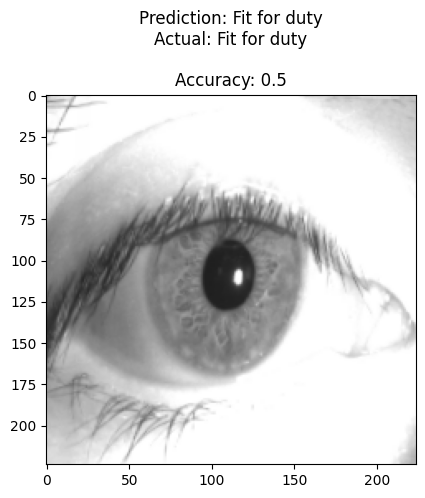

In [784]:
# testImagePath = 'images/test2.png'
# testImg = cv2.imread(testImagePath, cv2.IMREAD_GRAYSCALE)

r_in = random.randint(0, len(images) - 1)
print(f"Random index: {r_in}")

testImg = images[r_in]
testLabel = labels[r_in]
# testImg = cv2.resize(testImg, image_size)

plt.imshow(testImg, cmap='gray')

testImg = np.expand_dims(testImg, axis=0)

print(testImg.shape)

prediction = cnn_model.predict(testImg)
prediction = np.argmax(prediction[0])

totalTest +=1
correctTest += prediction==testLabel

prediction = 'Alcoholic' if prediction else 'Fit for duty'
testLabel = 'Alcoholic' if testLabel else 'Fit for duty'
plt.title(f'Prediction: {prediction}\nActual: {testLabel}\n\nAccuracy: {correctTest/totalTest}')

In [765]:
cnn_model.save("./Models/ResNet50Classification/NonAugmented.keras")